# Historical Sea Ice
Welcome to the **Historical Sea Ice** notebook! In this notebook, we will provide a more complex example of how to use accessvis. 

In this notebook we will plot the historical sea ice cover and animate the sea ice every day for one year.

The data used is available in project xp65 on gadi or it will automatically be downloaded. About 5GB will be used to download the full historical dataset.

In [1]:
import datetime
import glob
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pytz
import scipy
from tqdm.notebook import tqdm
import xarray as xr

import accessvis

In [2]:
hemisphere = 'south'
# hemisphere = 'north'

# The NOAA data we download ends around halfway through 2024, the rest of the data is in another dataset, see the full sea ice example

#Default to low res until we are running the final animation render
accessvis.resolution_selection(default=1)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('Ultra-hig…

## Download Data
On gadi, this data is available on xp65.
If you are not using gadi, please change base_dir below and it will download the relevant files.

NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4
* https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf
* https://nsidc.org/data/g02202/versions/4
* https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/
* https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/ ??

Note that the red warnings below may indicate the data has already been downloaded.

#### Historical Data
Downloading data from before the current year.

Note that on Gadi, you may not have write permissions and will not be able to update.

In [3]:
base_dir = '/g/data/xp65/public/apps/access-vis-data/'

#https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/
H = hemisphere[0].lower() + 'h'

#All years data
YEAR = None
fn = f'seaice_conc_daily_{H}_*.nc'

#For this example, limit to a single year
YEAR = 2023
fn = f'seaice_conc_daily_{H}_{YEAR}*.nc'
# Cached data location
datadir = f'{base_dir}noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/'
print(datadir)

if YEAR is not None:
    #Get a single year
    cmd = f"wget -nc -e robots=off https://noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/seaice_conc_daily_sh_{YEAR}_v04r00.nc"
    p = subprocess.Popen(cmd.split(), cwd=base_dir + f'noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/')
    p.wait()
else:
    #download all files if not existing
    cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/"
    p = subprocess.Popen(cmd.split(), cwd=base_dir)
    p.wait()
    

/g/data/xp65/public/apps/access-vis-data/noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/


File ‘seaice_conc_daily_sh_2023_v04r00.nc’ already there; not retrieving.



## Open Data:
Opening as an xarray dataset.

In [4]:
#No-dask: CPU times: user 1.44 s, sys: 640 ms, total: 2.08 s Wall time: 14.5 s
#With dask: CPU times: user 4.92 s, sys: 1.63 s, total: 6.54 s Wall time: 38.5 s
%time ds_sea_ice = xr.open_mfdataset(datadir + fn, combine='nested', concat_dim='tdim')
ds_sea_ice

CPU times: user 521 ms, sys: 59.8 ms, total: 580 ms
Wall time: 916 ms


<xarray.Dataset> Size: 1GB
Dimensions:                      (tdim: 365, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 3kB dask.array<chunksize=(365,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    projection                   (tdim) |S1 365B b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 153MB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (tdim, y, x) float32 153MB dask.array<chunksize=(365, 332, 316), meta=np.ndarray>
    longitude                    (tdim, y, x) float32 153MB dask.array<chunksize=(365, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2023-09-26T20:17:19Z
    time_coverage_start:       2023-01-01T00:00:00Z
    time_coverage_end:         2023-12-31T23:59:59Z

#### Basic information for the datasets:

In [5]:
latitude = np.array(ds_sea_ice['latitude'].sel(tdim=0))
longitude = np.array(ds_sea_ice['longitude'].sel(tdim=0))
print('Lat/Lon Extents:')
print(latitude[0][0], longitude[0][0])
print(latitude[-1][-1], longitude[-1][-1])

dates = np.array(ds_sea_ice['time']).astype('datetime64[D]')
print('Start/End Dates: ', min(dates), max(dates))

STEPS = len(dates)
print('Number of time steps:', STEPS)

Lat/Lon Extents:
-39.36487 -42.23257
-41.58345 135.0
Start/End Dates:  2023-01-01 2023-12-31
Number of time steps: 365


# Helper Functions

Helper functions to get the appropriate data:

In [6]:
def get_data_at(date):
    # This function retrieves all data at a given date. 
    
    itemindex = np.where(dates == date)
    T = itemindex[0]
    ts = dates[T] #.item() #.astype(datetime.datetime)
    assert(ts == date)
    dat = ds_sea_ice.sel(tdim=T)
    return dat

def get_ice_data_at(date):
    # This function retrieves only sea ice concentration at a given date. 
    
    dat = get_data_at(date)
    if dat is None:
        return dat
    dat = dat['cdr_seaice_conc']
    dat = dat.where(dat>0)
    data = np.array(dat)[0]


    if hemisphere == 'south':
        #Want to keep land max = 1.0 for antarctica, but clear islands
        #Clear tierra del fuego and nearby islands
        data[0:140,0:20] = 0.
    
        #Replace land with max ice
        data[data > 1.0] = 1.0
    else:
        #Replace land with max ice
        data[data > 1.0] = 0.0
    
    #Replace NaN with 0.0
    data[np.isnan(data)] = 0.0

    return data
   

## Plotting a sample of the data
Here we are plotting the sea ice cover for 1st June 2023.

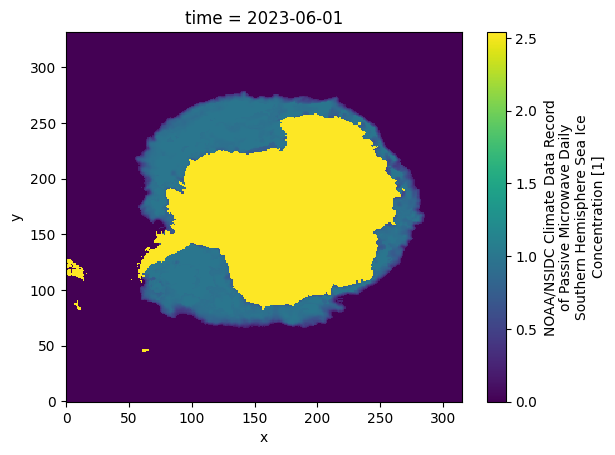

In [7]:
example_date = datetime.datetime.strptime("2023-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")

orig_data = get_data_at(example_date.date())['cdr_seaice_conc']
orig_data.plot()

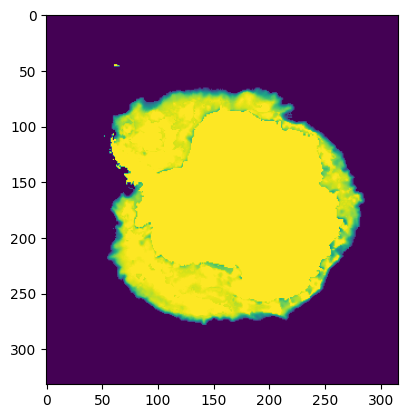

In [8]:
example_data = get_ice_data_at(example_date.date())
plt.imshow(example_data)

## Plotting
Now we will plot the data on top of the Earth. We begin by plotting the Earth.

From here on, the remaining code is fairly generic and you should be able to use it with your own dataset.


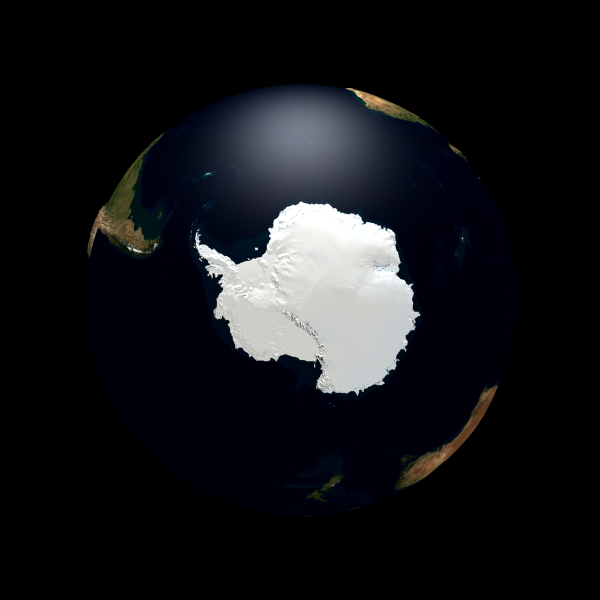

In [9]:
# lv = accessvis.plot_earth() # For a simple plot, this is all that is required.

# The following lines make the Earth pretty.
lv = accessvis.plot_earth(texture='bluemarble', waves=True, background='black', vertical_exaggeration=30, hemisphere=hemisphere[0].upper())
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])

lv.display(resolution=(600,600))

### Plotting Example Data


Lets overlay the data to see what it looks like.

In [10]:
# First we specify the patch of earth we want to plot over
patch = accessvis.earth_2d_plot(lv, latitudes=latitude, longitudes=longitude,
                                altitude=0.001, renderer='sortedtriangles', ambient=0.9) #, opaque=False)

In [11]:
# Getting the data
date = datetime.date(2023, 1, 1)
D = get_ice_data_at(date)

In [12]:
#patch.texture(D, flip=False) # This is OK, but uses a grayscale image.
#lv.display(resolution=(600,600))


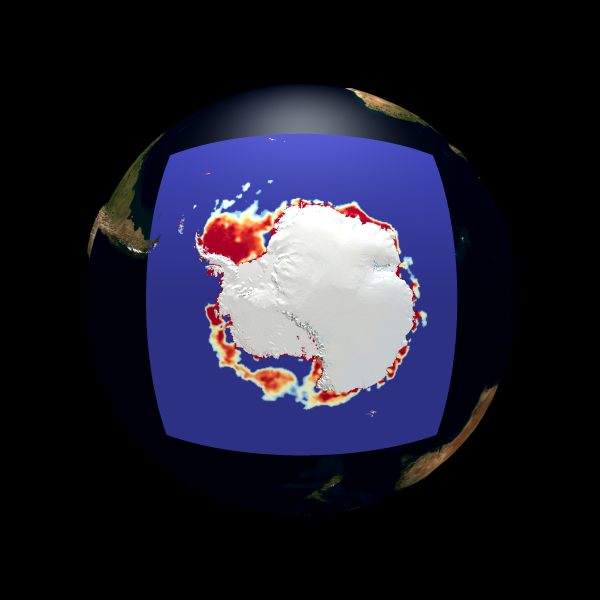

In [13]:
# Lets make it colourful instead.

colours = accessvis.array_to_rgba(D, colourmap='RdYlBu_r', maximum=1, minimum=0)
patch.texture(colours, flip=False)

lv.display(resolution=(600,600))


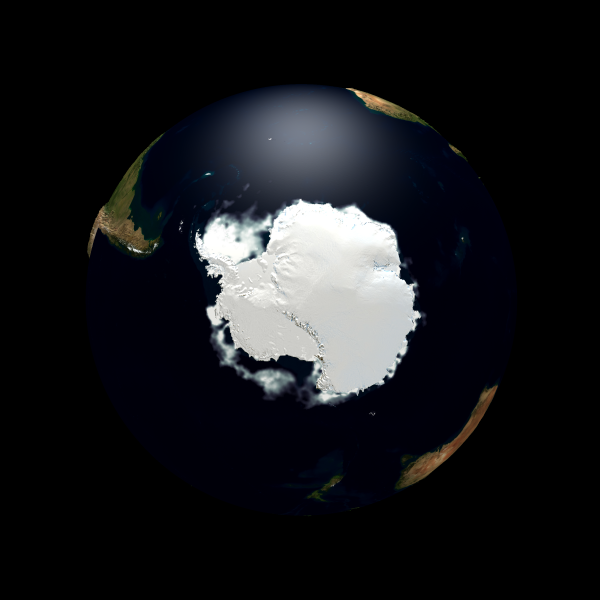

In [14]:
# Lets try for a more true colour plot with a transparent background
colours = accessvis.array_to_rgba(D, colourmap='bone', maximum=1, minimum=0, opacitymap=True)
patch.texture(colours, flip=False)

lv.display(resolution=(600,600))

### Simple Animation:
Below we are animating ice cover for the year 2001. Feel free to change the start date, or consider changing the code to graph the entire date range.

For more information about animations, see `04-Animations.ipynb`.

There are four parts to this:
1. Video creation context manager - handles video creation.
2. Loop through your data.
3. Update the earth with your data.
4. Render the next frame of the animation

In [15]:
start = datetime.date(2023, 1, 1)

# Video creation context manager - handles video creation.
with lv.video(filename=f'simple_sea_ice_{hemisphere}.mp4', fps=30, resolution=(500,500)):

    # Loop through your data.
    for i in tqdm(range(0, 365)):
        date = start + datetime.timedelta(days=i)
        D = get_ice_data_at(date)
        coloured = accessvis.array_to_rgba(D, colourmap='bone', maximum=1, minimum=0, opacitymap=True)

        # Update the earth with your data.
        patch.texture(coloured, flip=False)

        #Render the next frame of the animation
        lv.render()


  0%|          | 0/365 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

### Complex Animation
We have made a few changes to the above code. This allows us to:
* Add a widget dial indicating the time of year - `08-Add-Plots-And-Widgets.ipynb` for more information.
* Show the movement of the sun and changes on the earth's snow cover/etc across the year - `02-Sun-And-Seasons.ipynb` for more information.
* Spin the earth while animating - `01-Camera-Controls.ipynb` for more information.

In [ ]:
# initialising the season widget
wid = accessvis.SeasonWidget(lv=lv, scale=0.2, offset=(1,0), text_colour='white')

  0%|          | 0/365 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

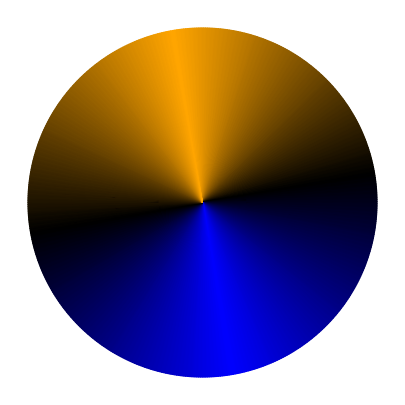

In [16]:
start = datetime.date(2023, 1, 1)

with lv.video(filename=f'sea_ice_{hemisphere}.mp4', fps=30, resolution=(500,500)):

    for i in tqdm(range(0, 365)):
        date = start + datetime.timedelta(days=i)
        D = get_ice_data_at(date)
        coloured = accessvis.array_to_rgba(D, colourmap='bone', maximum=1, minimum=0, opacitymap=True)
        patch.texture(coloured, flip=False)
        
        # Updating the season widget dial.
        wid.update_widget(date=date)

        # Rotating the earth a little in each frame
        lv.rotate('z', 0.2)

        # setting the position of the sun/colour of the earth.
        when = datetime.datetime(date.year, date.month, date.day, 0, 0, 0, 0, datetime.timezone.utc)
        accessvis.update_earth_datetime(lv, when=when, sunlight=True)
        
        lv.render()

In [17]:
# removing widget so we don't make duplicates if re-run.
wid.remove()

## Data sources:

National Snow and Ice Data Center

- https://noaadata.apps.nsidc.org/
- https://nsidc.org/data/user-resources/help-center/how-access-and-download-noaansidc-data
- https://nsidc.org/about/data-use-and-copyright

Historical Antarctic daily satellite data
( NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 )
Data set id: G02202
DOI: 10.7265/efmz-2t65
- https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/1978/ (-2023)
- https://nsidc.org/data/g02202/versions/4

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65. Date Accessed 02-19-2024.

Current year Antarctic daily satellite data
( Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 )
Data set id: G10016
DOI: 10.7265/tgam-yv28
- https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/
- https://nsidc.org/data/g10016/versions/2

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/tgam-yv28. Date Accessed 02-19-2024.

#### Earth satellite imagery and ocean/water masks
- https://earthobservatory.nasa.gov/features/BlueMarble

#### Topography:
- https://visibleearth.nasa.gov/images/73934/topography
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png

#### Bathymetry
- https://visibleearth.nasa.gov/images/73963/bathymetry
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73963/gebco_08_rev_bath_21600x10800.png

#### Textures and misc resources
https://www.manytextures.com/texture/23/sea-water/ Sea water by ManyTextures.com is licensed under a Creative Commons Attribution 4.0 International License. https://creativecommons.org/licenses/by/4.0/